In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import yfinance as yf


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


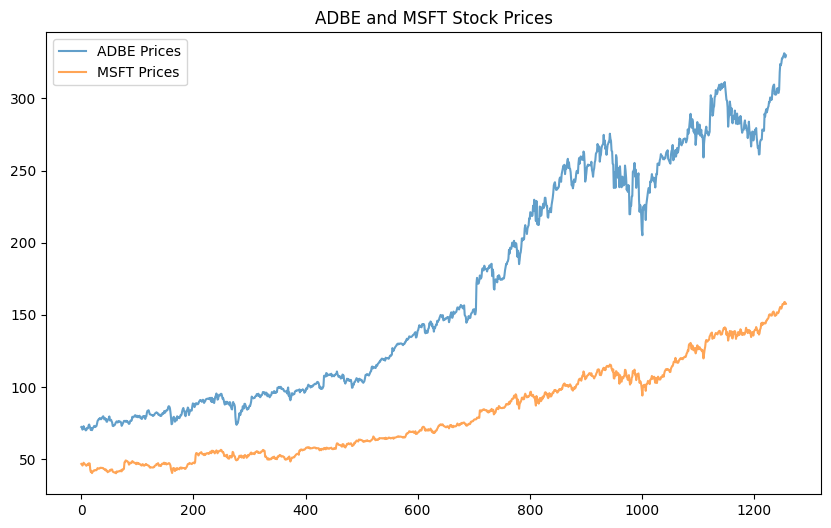

In [6]:
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data['Close']

start_date = '2015-01-01'
end_date = '2020-01-01'

adbe_prices = fetch_stock_data('ADBE', start_date, end_date)
msft_prices = fetch_stock_data('MSFT', start_date, end_date)

# Ensure data is in the correct shape
adbe_prices = adbe_prices.values.flatten()
msft_prices = msft_prices.values.flatten()

# Plot historical stock data
plt.figure(figsize=(10, 6))
plt.plot(adbe_prices, label='ADBE Prices', alpha=0.7)
plt.plot(msft_prices, label='MSFT Prices', alpha=0.7)
plt.title('ADBE and MSFT Stock Prices')
plt.legend()
plt.show()

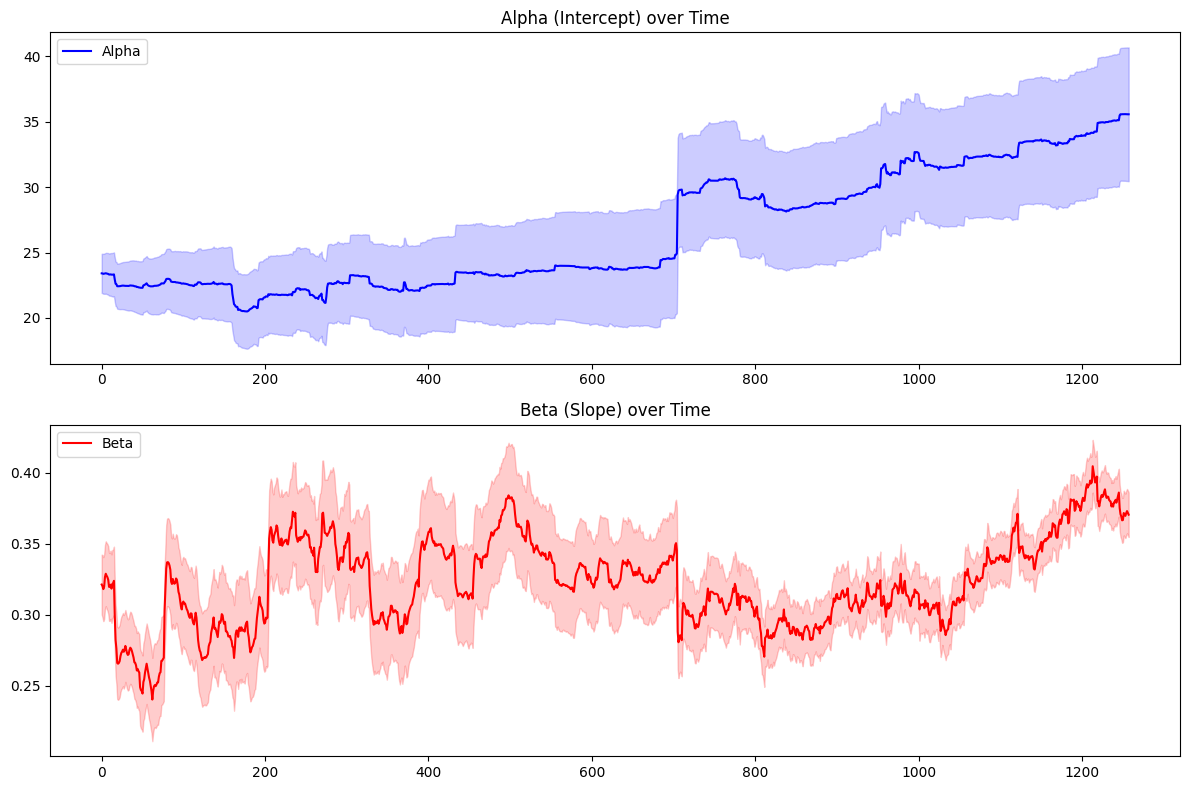

In [8]:
def kalman_estimation(x, y):
    # Ensure inputs are numpy arrays and 1D
    x = np.asarray(x).flatten()
    y = np.asarray(y).flatten()
    
    # Create observation matrix for each time step
    observation_matrices = np.zeros((len(x), 1, 2))
    for t in range(len(x)):
        observation_matrices[t] = [[1, x[t]]]
    
    # Initialize Kalman Filter with appropriate parameters
    kf = KalmanFilter(
        n_dim_obs=1,
        n_dim_state=2,
        observation_matrices=observation_matrices,
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.eye(2) * 100,
        transition_matrices=np.eye(2),
        observation_covariance=1.0,
        transition_covariance=0.01 * np.eye(2)
    )
    
    # Estimate parameters using EM algorithm
    kf = kf.em(y, n_iter=10)
    
    # Filter the data
    state_means, state_covariances = kf.filter(y)
    
    return state_means, state_covariances

def plot_kalman_results(dates, alpha, beta, state_covariances=None):
    plt.figure(figsize=(12, 8))
    
    # Plot alpha
    plt.subplot(2, 1, 1)
    plt.plot(dates, alpha, 'b-', label='Alpha')
    if state_covariances is not None:
        alpha_std = np.sqrt(state_covariances[:, 0, 0])
        plt.fill_between(dates, 
                        alpha - 2*alpha_std,
                        alpha + 2*alpha_std,
                        color='b', alpha=0.2)
    plt.title('Alpha (Intercept) over Time')
    plt.legend()
    
    # Plot beta
    plt.subplot(2, 1, 2)
    plt.plot(dates, beta, 'r-', label='Beta')
    if state_covariances is not None:
        beta_std = np.sqrt(state_covariances[:, 1, 1])
        plt.fill_between(dates, 
                        beta - 2*beta_std,
                        beta + 2*beta_std,
                        color='r', alpha=0.2)
    plt.title('Beta (Slope) over Time')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming adbe_prices and msft_prices are your input data
# and dates is a corresponding array of dates
state_means, state_covariances = kalman_estimation(adbe_prices, msft_prices)
alpha = state_means[:, 0]
beta = state_means[:, 1]

# Create date range if you don't have actual dates
dates = np.arange(len(alpha))

# Plot results
plot_kalman_results(dates, alpha, beta, state_covariances)

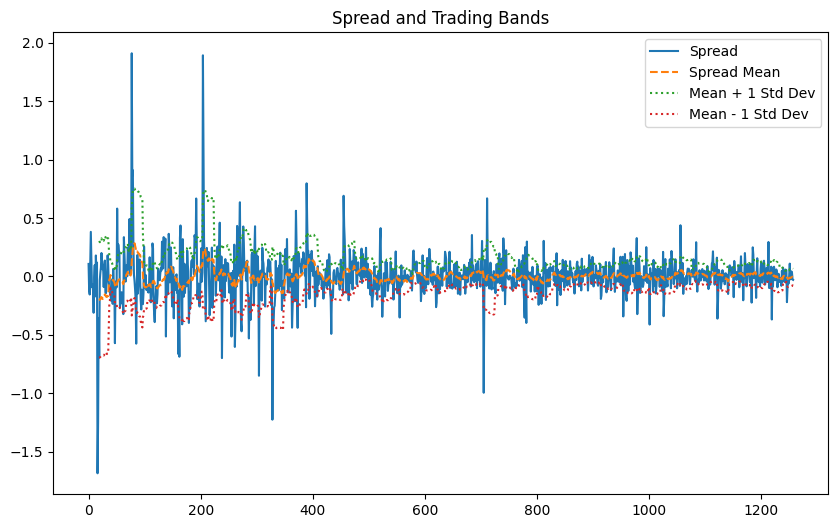

In [9]:
def generate_spread(y, x, alpha, beta):
    spread = y - (alpha + beta * x)
    return spread

spread = generate_spread(msft_prices, adbe_prices, alpha, beta)
spread_mean = pd.Series(spread).rolling(window=20).mean()
spread_std = pd.Series(spread).rolling(window=20).std()

# Plot spread
plt.figure(figsize=(10, 6))
plt.plot(spread, label='Spread')
plt.plot(spread_mean, label='Spread Mean', linestyle='--')
plt.plot(spread_mean + spread_std, label='Mean + 1 Std Dev', linestyle=':')
plt.plot(spread_mean - spread_std, label='Mean - 1 Std Dev', linestyle=':')
plt.title('Spread and Trading Bands')
plt.legend()
plt.show()


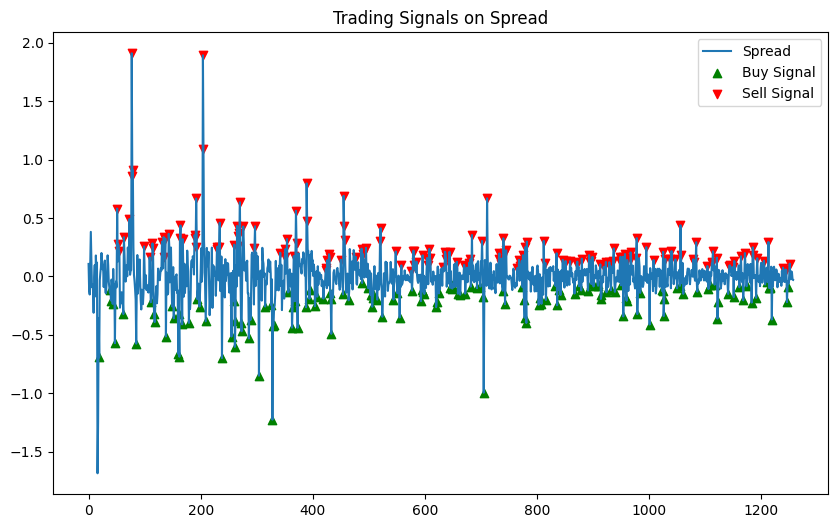

In [10]:
z_score = (spread - spread_mean) / spread_std
buy_signals = z_score < -1
sell_signals = z_score > 1

# Plot signals
plt.figure(figsize=(10, 6))
plt.plot(spread, label='Spread')
plt.scatter(np.where(buy_signals)[0], spread[buy_signals], color='green', label='Buy Signal', marker='^')
plt.scatter(np.where(sell_signals)[0], spread[sell_signals], color='red', label='Sell Signal', marker='v')
plt.title('Trading Signals on Spread')
plt.legend()
plt.show()

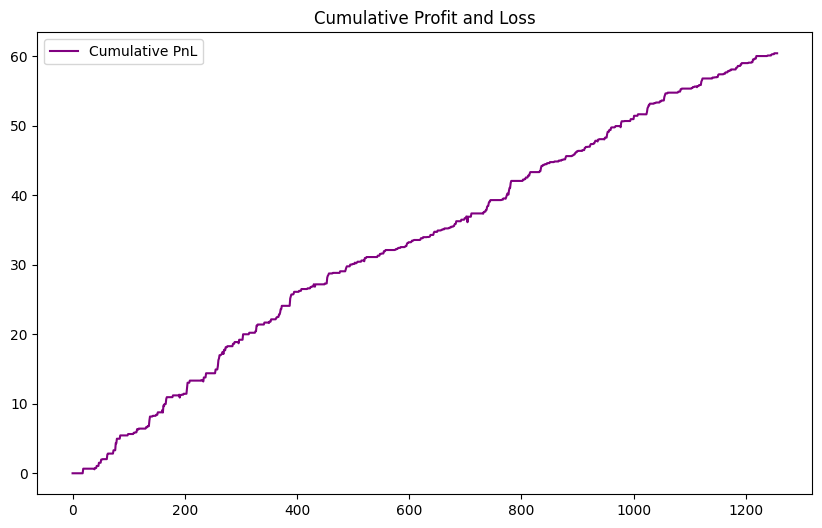

In [11]:
def backtest(spread, buy_signals, sell_signals):
    positions = np.zeros(len(spread))
    positions[buy_signals] = 1
    positions[sell_signals] = -1
    pnl = positions[:-1] * (spread[1:] - spread[:-1])
    cumulative_pnl = np.cumsum(pnl)
    return cumulative_pnl

cumulative_pnl = backtest(spread, buy_signals, sell_signals)

# Plot cumulative PnL
plt.figure(figsize=(10, 6))
plt.plot(cumulative_pnl, label='Cumulative PnL', color='purple')
plt.title('Cumulative Profit and Loss')
plt.legend()
plt.show()
